# Long-Duration Energy Storage Example
---
In this example, we will show how to use and modify the long duration energy storage (LDES) parameters in the hybrid plant simulation. The LDES model is built inside of the battery module, so the parameters are very similar to the battery storage model. In this example we will model a vanadium redox flow battery (VRFB), but we have written the model in a general way so that many types of long-duration energy storage can be modeled reasonably easily.

**NOTE**: Initializing the LDES model may slow down the `HoppInterface` in Jupyter Notebooks. This is a known limitation; initialization is faster when run from a `.py` script.

### Import Required Modules
Begin by importing the necessary modules for the simulation.

In [1]:
import numpy as np

from hopp.simulation import HoppInterface
from hopp.utilities import load_yaml
from hopp.tools.dispatch.plot_tools import (
    plot_generation_profile
)

/Users/kbrunik/github/HOPP/examples/log/hybrid_systems_2025-04-29T14.35.18.231197.log


### Create the HOPP Model
To generate the HOPP Model, instantiate the `HoppInterface` class and supply the required YAML configuration.

`HOPPInterface` is capable of handling dictionary input as well as class instances. Here we demonstrate this by loading the YAML file as a dict, modifying it to include our site information, then passing it as an argument to `HoppInterface`. This is useful for programmatic configuration of simulation configs.

For LDES simulations, the YAML configuration should resemble those used for batteries in the hybrid system examples. The LDES system is defined within the battery section of the technologies block, using the key parameters shown below.

The key differences for LDES compared to a standard battery setup are:

- Set `system_model_source` to `"hopp"`.
- Set `chemistry` to `"LDES"`.

An example YAML snippet for an LDES system:

```yaml
technologies:
    battery: # VRDB
        system_capacity_kwh: 100000
        system_capacity_kw: 10000
        minimum_SOC: 20.0
        maximum_SOC: 100.0
        initial_SOC: 90.0
        system_model_source: "hopp"
        chemistry: "LDES"
        fin_model: !include default_fin_config_ldes.yaml
```

In [2]:
hopp_config = load_yaml("./inputs/11-load-following-long-duration-energy-storage.yaml")

# set SiteInfo default load
setpoint_kw = float(10 * 1000)
DEFAULT_LOAD = setpoint_kw*np.ones((8760))/1000
hopp_config["site"]["desired_schedule"] = DEFAULT_LOAD

### Set Up Battery Replacement and O&M Costs
In this section, we configure the financial model for the LDES system by specifying a battery replacement schedule and adjusting the battery operation and maintenance (O&M) costs.

#### 1. Enable a User-Defined Replacement Schedule

First, we alert the model that a custom battery replacement schedule will be provided by setting the `batt_replacement_option` to `2`:



In [3]:
hopp_config["technologies"]["battery"]["fin_model"]["battery_system"]["batt_replacement_option"] = 2

#### 2. Define the Replacement Schedule

Next, we create a replacement schedule where the battery is refurbished every 15 years, and the refurbishment cost is set at 50% of the original capital cost:

In [5]:
project_life_years = 25
refurb = [0]*project_life_years
battery_life_years = 15
for i in range(battery_life_years-1, project_life_years, battery_life_years):
    refurb[i] = 0.5


This creates a list (`refurb`) where each element represents the replacement cost (as a fraction of initial CAPEX) in each project year.

We then assign this schedule to the HOPP configuration:

In [6]:
hopp_config["technologies"]["battery"]["fin_model"]["battery_system"]["batt_replacement_schedule_percent"] = refurb

#### 3. Adjust Battery Operation and Maintenance (O&M) Costs
Battery O&M costs can be based on both power (\\$ per kW) and energy capacity (\\$ per kWh). However here we've chosen to represent the battery O&M as a \$ per kW value.

We first calculate the total O&M cost by combining both per-kW and per-kWh components:

In [7]:
# set battery om per kw including per kwh cost - om per kwh not included internally
battery_rating_kw = hopp_config["technologies"]["battery"]["system_capacity_kw"]
battery_rating_kwh = hopp_config["technologies"]["battery"]["system_capacity_kwh"]
batt_om_per_kwh = hopp_config["config"]["cost_info"]["battery_om_per_kwh"]
batt_om_per_kw = hopp_config["config"]["cost_info"]["battery_om_per_kw"]

# this is how to include om per kwh capacity costs
total_batt_om_per_kw = (battery_rating_kw*batt_om_per_kw + battery_rating_kwh*batt_om_per_kwh)/battery_rating_kw
hopp_config["config"]["cost_info"]["battery_om_per_kw"] = total_batt_om_per_kw

Finally, we remove the `battery_om_per_kwh` input from the config, since we've already included O&M costs through the `battery_om_per_kw` input:

In [8]:
hopp_config["config"]["cost_info"].pop("battery_om_per_kwh")

0.0

### Create the Simulation Model
Instantiate the `HoppInterface` class by providing our modified configuration dict.

In [9]:
hi = HoppInterface(hopp_config)

### Modify Dispatch Parameter for LDES

When modeling LDES, a dispatch parameter you may want to adjust compared to a shorter-duration battery is:

- `round_trip_efficiency`

```{note}
HOPP LDES does not currently account for self discharge.
```

You can modify this parameter directly on the `dispatch` object after creating your HOPP model. Here's an example:

In [10]:
# set round trip efficiency
hi.system.battery.dispatch.round_trip_efficiency = 80.0

### Run the Simulation
Simulate the hybrid renewable energy system for a specified number of years (in this case, 25 years).

In [11]:
hi.simulate(project_life=project_life_years)

### Print Simulation Results
Access and display various simulation results, including annual energies, net present values (NPVs), and total revenues.

In [12]:
hybrid_plant = hi.system

print("Annual Energies (kWh):")
print(hybrid_plant.annual_energies)

print("\n Percentage of timesteps the load is met:")
print(hybrid_plant.grid.time_load_met)

print("\n Total Missed Load:")
print(sum(hybrid_plant.grid.missed_load), "kWh")

print("\n Percentage of the load that is missed:")
print(hybrid_plant.grid.missed_load_percentage)

Annual Energies (kWh):
{"pv": 11234203.2087558, "wind": 80310545.93316662, "battery": -1214.332420000269, "hybrid": 91543534.80950251}

 Percentage of timesteps the load is met:
78.52739726027397

 Total Missed Load:
417465809.7516137 kWh

 Percentage of the load that is missed:
19.062365742082815


### Visualize Simulation Results (Optional)
Optionally, you can visualize the simulation results using plots. Several functions are provided for plotting battery output, generation profiles, and dispatch errors.

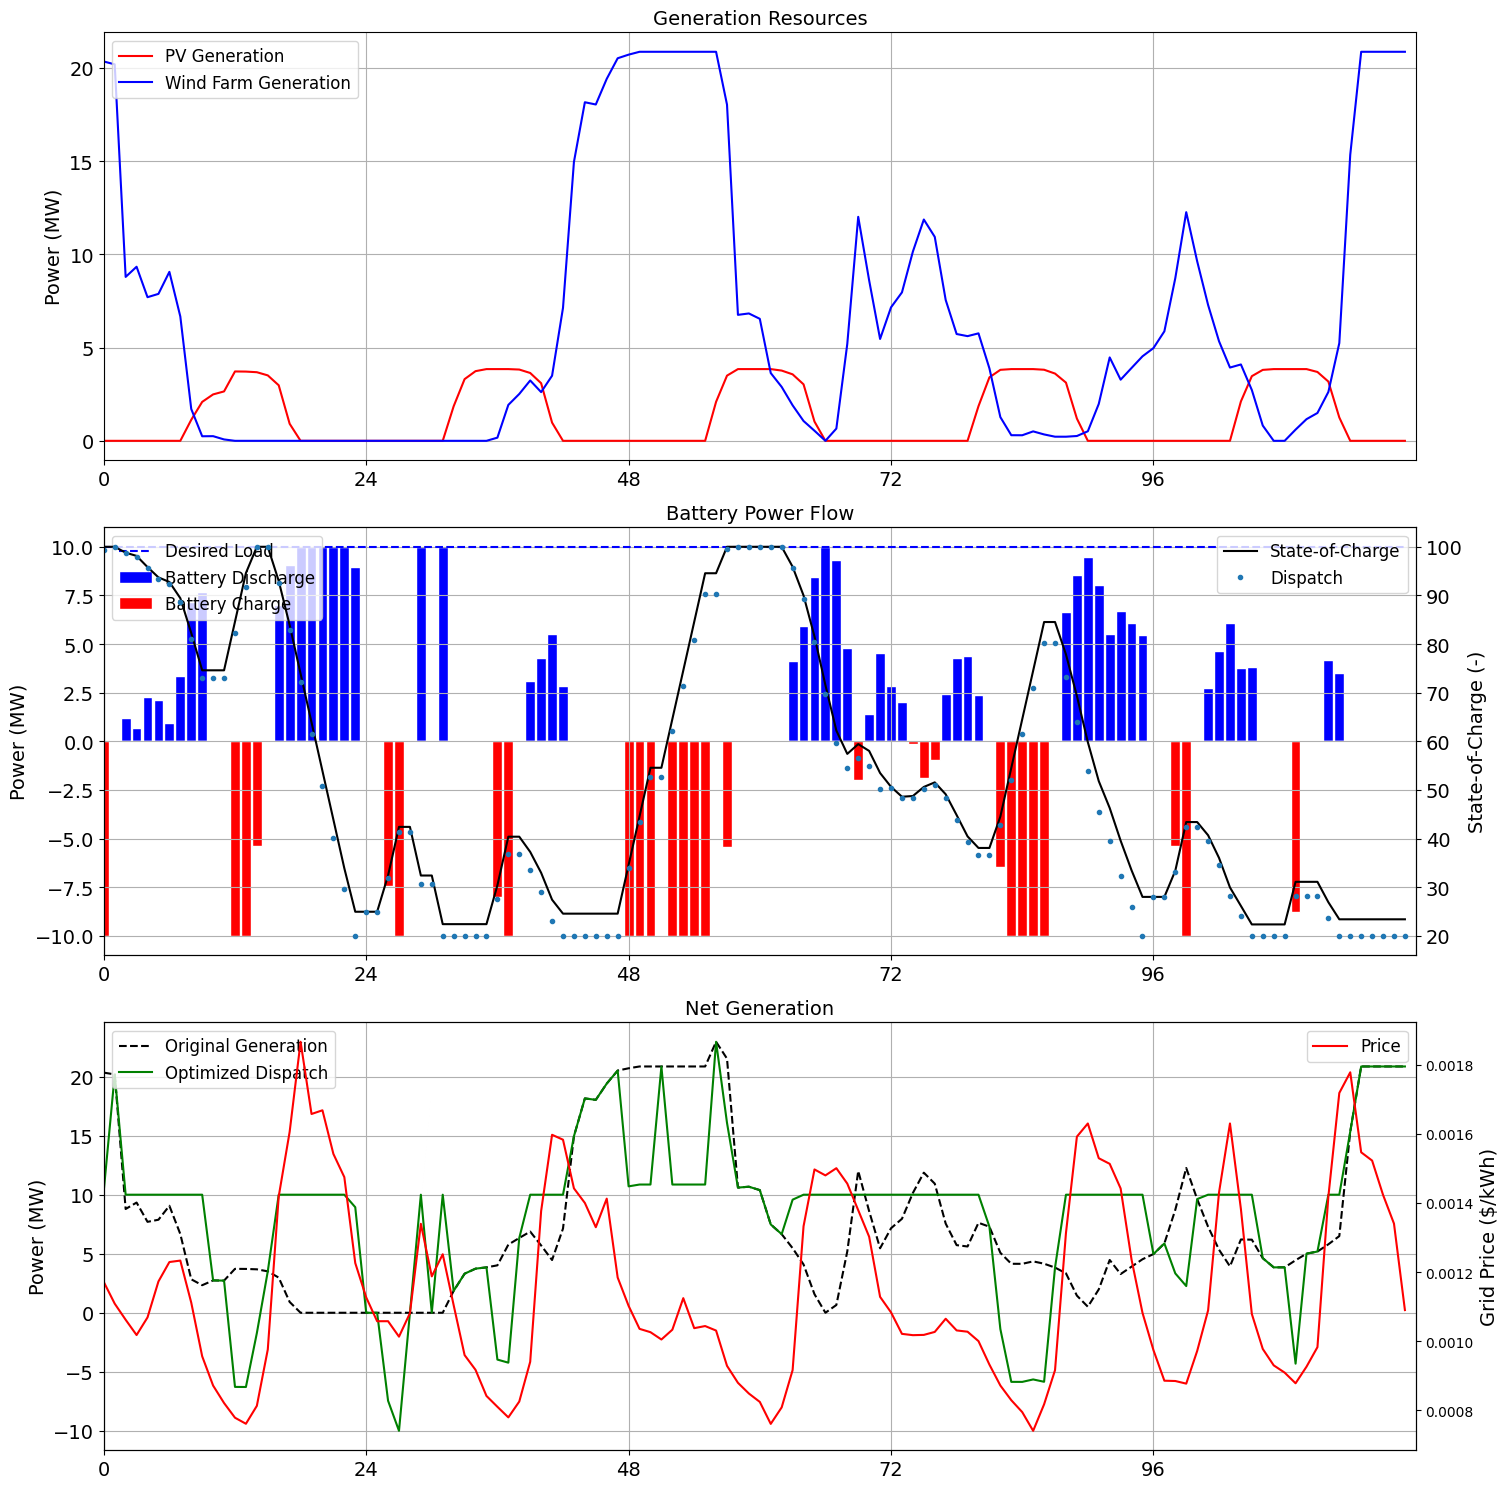

In [13]:
plot_generation_profile(hybrid_plant)